# Image Classification with SciKit-Learn

In this notebook, we'll explore some basic principles for building a classifier for images. Our classifier will be pretty simple, and will differentiate between circles, triangles, and squares.

In [1]:
#from google.colab import drive
#drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [1]:
def prep_data (folder):
    # iterate through folders, assembling feature, label, and classname data objects
    import os
    import numpy as np
    import matplotlib.pyplot as plt

    class_id = 0
    features = []
    labels = np.array([])
    classnames = []
    for root, dirs, filenames in os.walk(folder):
        for d in sorted(dirs):
            print("Reading data from", d)
            # use the folder name as the class name for this label
            classnames.append(d)
            files = os.listdir(os.path.join(root,d))
            for f in files:
                # Load the image file
                imgFile = os.path.join(root,d, f)
                img = plt.imread(imgFile)
                # The image array is a multidimensional numpy array
                # - flatten it to a single array of pixel values for scikit-learn
                # - and add it to the list of features
                features.append(img.ravel())

                # Add it to the numpy array of labels
                labels = np.append(labels, class_id )
            class_id  += 1

    # Convert the list of features into a numpy array
    features = np.array(features)

    return features, labels, classnames


# The images are in a folder named 'shapes/training'
training_folder_name =  'data/shapes/training'

# Prepare the image data
features, labels, classnames = prep_data(training_folder_name)
print(len(features), 'features')
print(len(labels), 'labels')
print(len(classnames), 'classes:', classnames)

Reading data from circle
Reading data from square
Reading data from triangle
1200 features
1200 labels
3 classes: ['circle', 'square', 'triangle']


Let's verify the shapes of the arrays -  we should have a two-dimensional array of features (each image is itself an array), and one dimensional array of labels (each label is an integer value).

In [2]:
print('Feature Shape:',features.shape)
print('Labels Shape:',labels.shape)

Feature Shape: (1200, 49152)
Labels Shape: (1200,)


## Split the data
Now that the image data is prepared, we can split it into training (70%) and test (30%) subsets:

In [11]:
# split into training and testing sets
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(features, labels, test_size=0.30)

print('Training records:',Y_train.size)
print('Test records:',Y_test.size)

Training records: 840
Test records: 360


## Train the classification model

Now we'll use the prepared image data to train a model.

In this case, we'll define a pipeline that contains two steps:
1. Normalize the pixel values so that they are scaled between 0 and 1 - this can prevent high pixel density values from dominating the model training.
2. Train the model using a *Decision Tree* algorithm for classification (this is one of many algorithms supported by Scikit-Learn - see the [documentation](https://scikit-learn.org/stable/user_guide.html) for details)

*(This may take a few minutes)*

In [15]:
# Train the model
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeClassifier

# Convert the training features to floats so they can be scaled
X_train_float = X_train.astype('float64')

# Our pipeline performs two tasks:
#   1. Normalize the image arrays
#   2. Train a classification model
img_pipeline = Pipeline([('norm', MinMaxScaler()),
                         ('classify', DecisionTreeClassifier()),
                        ])

# Use the pipeline to fit a model to the training data
print("Training model...")
clf = img_pipeline.fit(X_train_float, Y_train)

print('classifier trained!')

Training model...
classifier trained!


## Evaluate the model
With our model trained, we'll use it to predict labels for the test data and evaluate its precision, recall, and simple accuracy using the known labels. Then we'll plot the confusion matrix to evaluate how well the model performs for each class label.

Classifier Metrics:
              precision    recall  f1-score   support

      circle       0.91      0.88      0.89       120
      square       0.89      0.91      0.90       119
    triangle       1.00      1.00      1.00       121

    accuracy                           0.93       360
   macro avg       0.93      0.93      0.93       360
weighted avg       0.93      0.93      0.93       360

Accuracy: 93.06%

 Confusion Matrix:


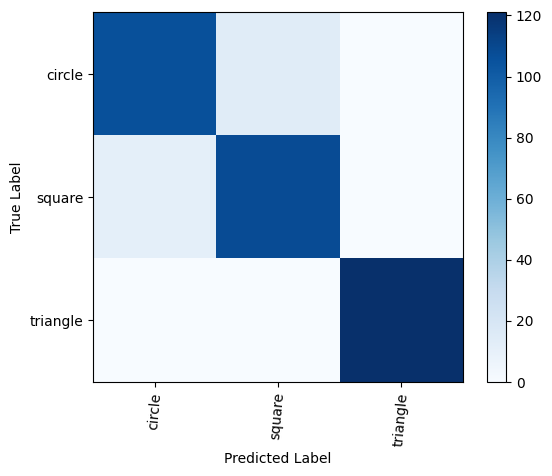

In [16]:
# Evaluate classifier
from sklearn import metrics
from sklearn.metrics import accuracy_score, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt

# Convert the test features for scaling
X_test_float = X_test.astype('float64')

print('Classifier Metrics:')
predictions = clf.predict(X_test)
print(metrics.classification_report(Y_test, predictions, target_names=classnames))
print('Accuracy: {:.2%}'.format(metrics.accuracy_score(Y_test, predictions)))

print("\n Confusion Matrix:")
cm = confusion_matrix(Y_test, np.round(predictions, 0))
# Plot confusion matrix as heatmap
plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
plt.colorbar()
tick_marks = np.arange(len(classnames))
plt.xticks(tick_marks, classnames, rotation=85)
plt.yticks(tick_marks, classnames)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

### Save the Model
Now that we have trained the model, we can save it, and use it later to predict classes from new images.

In [17]:
# Save the trained model
import sys
import os
import pickle

print ("Exporting the model")
file_stream = open('shape_classifier.pkl', 'wb')
pickle.dump(clf, file_stream)
file_stream.close()

Exporting the model


## Use the model with new data
Now we can use the model to classify new images.

### Create Functions to Prepare Data and Get Class Predictions
Let's create a couple of functions to:

- Resize new images to match the size on which the model was trained.
- Submit the new images to the model and retrieve the predicted classes.

In [18]:
# Helper function to resize image
def resize_image(src_img, size=(128,128), bg_color="white"):
    from PIL import Image

    # rescale the image so the longest edge is the right size
    src_img.thumbnail(size, Image.Resampling.LANCZOS)

    # Create a new image of the right shape
    new_image = Image.new("RGB", size, bg_color)

    # Paste the rescaled image onto the new background
    new_image.paste(src_img, (int((size[0] - src_img.size[0]) / 2), int((size[1] - src_img.size[1]) / 2)))

    # return the resized image
    return new_image

# Function to predict the class of an image
def predict_image(classifier, image_array):
    import numpy as np

    # These are the classes our model can predict
    classnames = ['circle', 'square', 'triangle']

    # Predict the class of each input image
    predictions = classifier.predict(image_array)

    predicted_classes = []
    for prediction in predictions:
        # And append the corresponding class name to the results
        predicted_classes.append(classnames[int(prediction)])
    # Return the predictions
    return predicted_classes

print("Functions created - ready to use model for inference.")

Functions created - ready to use model for inference.


### Predict Image Classes
Now we're ready to use the model for predicting (often referred to as *inferencing*) the classes of some new images.

Importing the model


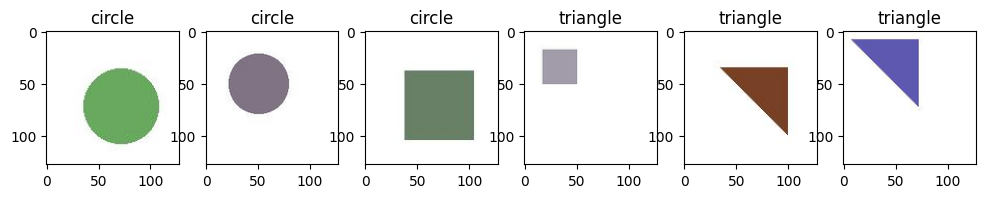

In [19]:
import os
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt

# Load the model
print("Importing the model")
file_stream = open('shape_classifier.pkl', 'rb')
clf = pickle.load(file_stream)
file_stream.close()

#get the list of test image files
test_folder = 'data/shapes/test'
test_image_files = os.listdir(test_folder)

# Empty array on which to store the images
image_arrays = []

size = (128,128)
background_color = "white"

fig = plt.figure(figsize=(12, 8))

# Get the images and show the predicted classes
for file_idx in range(len(test_image_files)):
    img = Image.open(os.path.join(test_folder, test_image_files[file_idx]))

    # resize the image so it matches the training set - it  must be the same size as the images on which the model was trained
    resized_img = np.array(resize_image(img, size, background_color))

    img_shape = np.array(resized_img).shape

    # Add the image to the array of images
    image_arrays.append(resized_img.ravel())

# Get predictions from the array of image arrays
# Note that the model expects an array of 1 or more images - just like the batches on which it was trained
predictions = predict_image(clf, np.array(image_arrays))

# plot easch image with its corresponding prediction
for idx in range(len(predictions)):
    a = fig.add_subplot(1,len(predictions),idx+1)
    img = image_arrays[idx].reshape(img_shape)
    imgplot = plt.imshow(img)
    a.set_title(predictions[idx])


## Learn More about Scikit-Learn
Take a look at the [Scikit-Learn documentation](https://scikit-learn.org/stable/documentation.html)